# Introduction

It was a bit difficult to explain any of them outside the context of others. Now that they've been explained [for single stages](demonstrations/E_CMB_ML_framework.ipynb) and [for the whole pipeline](demonstrations/F_CMB_ML_pipeline.ipynb) I can illustrate how I use them with less worry about overwhelming the reader.

In this notebook, I want to tackle multiple simulations and splits. This should:
- Drive home the advantage of using Assets with path_templates
- Introduce the `Split` object
- Show a few different structures for Executors
- Point out a few other practices that I think are good <!--PLEASE GIVE FEEDBACK ON THIS. I'M MAKING THIS UP. I'M A CHILD LOST IN THE WOODS-->

I'll cover three different Executors, which differ in how they process multiple simulations:
- [A simple Executor](#serially-iterating-executor) that iterates slowly (relatively)
- An Executor that uses multiprocessing to iterate quickly
- An Executor that sets up and uses a PyTorch DataLoader

# Example

In this notebook, I'll continue with the example of wanting to convert a power spectrum into a map. But this time, I'll consider that there's a single power spectrum and produce many realizations for hypothetical Training, Validation, and Test splits. (This is likely contrived. Some independent variable is needed so that a network is trained to prediction something, but this suffices for now.)

To do this, I introduce another object: a `Split`.

# Dataset Splits

## Configuration

The CMB-ML dataset is split into Training, Validation, and Test subsets. The size of each split is set in a [split.yaml](../cfg/splits/3-3.yaml) configuration file (there are many).
```yaml
name: "3-3"
Train:
  n_sims: 3
Valid:
  n_sims: 3
  n_sims_cap: ${n_infer_cap}
Test:
  n_sims: 3
  n_sims_cap: ${n_infer_cap}
run_inference_on: ${run_inference_on}
```

- `name`: Used for file paths. 
  - For small, debugging, splits I will use 3-3 to mean three splits with three simulations each.
  - For larger, more practical, splits I will use the total number of simulations (e.g., 1450 or 2450)
- `Train` / `Valid` / `Test`: The name of a split
  - CMB-ML can also use `Test1`, `Test2`, etc., if different test distributions are to be examined
  - Use of other split names would need to be matched elsewhere in configurations an possibly in Python
- `n_sims`: The total number of simultions in this split
- `n_sims_cap`: When debugging, it is faster to run inference on a portion of the dataset only. This key enables that.
  - `${n_infer_cap}` causes Hydra to interpolate the value (get it from elsewhere). In this case, it will look for `n_infer_cap` in the top level configuration. This is a shortcut I use so that the parameter can be in the correct place in the configuration YAMLs, but I can change it more easily at a single location.
- `run_inference_on`: Whether to run Prediction (and later) stages on "Test" or "Valid" data. I try to use "Test" only for final runs, and "Validation" while developing.
  - Again, this parameter is set at the top level, but I believe it "belongs" here.

Some stages of the pipeline may only apply to certain splits. For instance, when predicting results, I don't need to run on the training datasplit. In this case, the [pipeline YAML](../cfg/pipeline/pipe_model_patch_nn.yaml) has a key to note this:
```yaml
predict: &final_inference
  assets_out:
    cmb_map: 
      handler: HealpyMap
      path_template: "{root}/{dataset}/{working}{stage}/{split}/{sim}/cmb_map_pred_{epoch}.fits"
  assets_in:
    obs_maps: {stage: make_sims}
    lut: {stage: make_lut}
    dataset_stats: {stage: get_dataset_stats}
    model: {stage: train}
  splits:
    - ${splits.run_inference_on}
  epochs: ${use_epochs}
  dir_name: PatchNN_F_Predict
  make_stage_log: True
```

The lines
```yaml
  splits:
    - ${splits.run_inference_on}
```
tell the Executor to only run on the split marked that way in the splits YAML.

Similar patterns can be seens elsewhere. For instance, the preprocessing stage for that pipeline is only applied to the Training and Validation datasplits; in this particular case, preprocessing of the Test datasplit occurs during inference.

## `Split` object

To handle splits within executors, we have the `Split` class. An instance of this class is created for each split. It retains the name and number of simulations. It could be extended to track additional variables. It also has a method, `iter_sims()` that produces an iterator over all simulations within the split (referring to each simulation as an integer index). Examples of this will be provided below.

<!-- Generally, splitting of a dataset is done by producing one full dataset and randomly assigning elements to the different splits. The current system does this in effect, because it draws each simulation at random from a hypothetical source distribution. I do generate them pre-labelled into a category, but this is immaterial. -->

<!-- When the project was started, I wanted to investigate the impact of different distributions on both training and inference.
This may be picked up again in the future. 
There are vestiges of this intention in the code, such as the ps_fidu_fixed parameter within a split. This would enable me to use a set of simulations with a single fiducial power spectrum, checking where a trained model struggles. -->

# Set-Up

I have to again set a few things up so that the CMB-ML framework plays nice with Jupyter.

In [1]:
# Ignore this cell. 
# It's needed for the notebook to work, not something to learn.

import sys
import os

# Set the local_system
os.environ["CMB_ML_LOCAL_SYSTEM"] = "generic_lab"

# Add the path to the parent directory so I can import cmb-ml
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, repo_root)

In [2]:
import logging
from hydra import compose, initialize
import numpy as np
import healpy as hp

from cmbml.core import PipelineContext
from cmbml.core import BaseStageExecutor, Asset
from cmbml.core.asset_handlers import TextPowerSpectrum, HealpyMap, Config

In [3]:
logger = logging.getLogger("F_Tutorial")
logger.setLevel(logging.DEBUG)

# Outside of a notebook, Hydra will handle the logging. 
handler = logging.StreamHandler()  # StreamHandler sends logs to sys.stdout by default
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

In [4]:
from omegaconf import OmegaConf
from hydra.core.hydra_config import HydraConfig

# There are better ways to do this outside of notebooks.
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", return_hydra_config=True)
    HydraConfig.instance().set_config(cfg)

# Basic Executor

The first stage in this demonstration pipeline will produce a single power spectrum and save it to disk. I've made some adjustments from the previous version of this executor ([this notebook](demonstrations/E_CMB_ML_framework.ipynb)).

In [5]:
class MakePSExecutor(BaseStageExecutor):
    def __init__(self, cfg):
        super().__init__(cfg, stage_str="ps_setup")

        self.out_cmb_ps: Asset = self.assets_out["cmb_ps"]
        out_cmb_ps_handler: TextPowerSpectrum  # Reference to the handler

        # "Power spectrum model" as a parameter
        self.ps_model = cfg.model.ps
        self.ells = cfg.model.max_ell

    def execute(self):
        # The following logging line is always used at the start of an execute() method:
        logger.debug(f"Running {self.__class__.__name__} execute()")

        ell = np.arange(self.ells)
        # Create the power spectrum from the model
        ps = np.poly1d(self.ps_model)
        self.out_cmb_ps.write(data=ps(ell))
        logger.debug(f"CMB power spectrum written to {self.out_cmb_ps.path}")

One change is to include a reference to the handler used for the asset. The line:
```python
out_cmb_ps_handler: TextPowerSpectrum
```
doesn't have any impact on the way the code runs. Python sees that the variable is never used, so there's only negligible computational cost to including it. However, it has a huge benefit to me as I write an Executor: I can very quickly find the code for the AssetHandler using my IDE. <!-- This pattern has a huge flaw: duplication. There's NOTHING that forces the handler listed to match the one in the config file. I have ideas for better solutions to this, but haven't implemented any. This reflects a short-coming of using Hydra, since the class of the asset handler isn't in a form IDE's currently recognize -->

In this case, I'm getting the power spectrum as a polynomial model fit to a small range of the data. Previously, those were hard-coded values. Here, I've remove the hard-coding. This gives me more flexibility. Instead, the spectrum is included as a parameter from the configuration file $^\dagger$. When creating executors I strive to **set variables in the __init__** method, pulling values from the configurations. 

Early on when I was putting together CMB-ML, I simply had
```python
self.cfg = cfg  # Do not do this!
```
in my executors. This defers pulling what I need from the configurations until the `execute()` function. It seems simpler, but really bit me when a reference to the configuration was incorrect (e.g. "cfg.model.power_spectrum" instead of "cfg.ps_model"). That would cause the executor to crash. Instead, by setting class variables for everything I need in the `__init__()` method, I fail faster and simplify debugging. <!-- ideally, I would take this to a next level, and have more extensive validation of the Hydra configs -->

I've also added the use of `logger`. I try to use it sparingly.

$^\dagger$ This is not the correct way to generate a power spectrum, it's just what's suitable for a small demonstration. Also, the model is more "data" than a "parameter"; hard-coding it into the configuration isn't the best idea. Instead, I'd prefer to save it to a text file and use an Asset to manage the values. That makes this more extensible.

I check each stage to ensure they work individually. I often change parameters in my configs for "debug" settings while doing so.

In [6]:
# Shorter version of next cell, but less useful output b/c logging...
# executor = MakePSExecutor(cfg)

In [7]:
pipeline_context = PipelineContext(cfg)

pipeline_context.add_pipe(MakePSExecutor)

pipeline_context.prerun_pipeline()

try:
    pipeline_context.run_pipeline()
except Exception as e:
    # I typically use the logging library for these messages
    logger.warning("An exception occured during the pipeline.", exc_info=e)
    raise e
finally:
    logger.info("Pipeline completed.")

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/A_PS_Setup/cmb_dummy_ps.fits
Skipping stage logs for stage MakePSExecutor.
Pipeline completed.


# Serially Iterating Executor

The simplest form for an Executor will iterate using for-loops. Recall the previous version of the Executor:

```python
class PS2MapExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="ps2map")

        self.out_map_asset = self.assets_out["cmb_map"]
        self.in_ps_asset = self.assets_in["cmb_ps"]

    def execute(self) -> None:
        ps = self.in_ps_asset.read()
        print(f"Power spectrum read from {self.out_map_asset.path}")
        cmb = hp.synfast(ps, nside=256)
        self.out_map_asset.write(data=cmb)
        print(f"Map written to {self.out_map_asset.path}")
        return
```

This produced a single output map.

That map was written without keeping track of units. I prefer to do so, so I need to use PySM3's units module.

In [8]:
import pysm3.units as u

I'm now extending the method, producing multiple simulations for different data splits. Here's how I do that:

In [9]:
class PS2MapExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="ps2map")

        self.out_map_asset = self.assets_out["cmb_map"]
        out_map_handler: HealpyMap  # Specify handler

        self.in_ps_asset = self.assets_in["cmb_ps"]
        in_ps_handler: TextPowerSpectrum

        # Set aside a placeholder for the power spectrum
        self.ps = None

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute()")
        # Load the power spectrum, just once
        self.ps = self.in_ps_asset.read()
        logger.debug(f"Power spectrum read from {self.in_ps_asset.path}")

        for split in self.splits:
            logger.debug(f"Working on split {split.name}")
            with self.name_tracker.set_context("split", split.name):
                self.process_split(split)

    def process_split(self, split):
        for sim_num in split.iter_sims():
            logger.debug(f"Working on sim {sim_num:04d}")
            with self.name_tracker.set_context("sim_num", sim_num):
                self.process_sim()

    def process_sim(self):
        cmb = hp.synfast(self.ps, nside=256)
        cmb = cmb * u.uK_CMB
        self.out_map_asset.write(data=cmb)
        logger.debug(f"Map written to {self.out_map_asset.path}")
        return

The changes:
- Handlers for input and output Assets are specified.
- `self.ps` is created and set to None in the `__init__()` method.
  - Creating new instance variables outside of initialization is poor practice.
  - I don't load the data during initialization; reading data (especially maps) will slow down the `pipeline_prerun()`.
- The power spectrum is read at the start of `execute()`. 
  - It's the same data for all simulations; I don't want to read it multiple times
  - I wait until execution to read data from files <!-- I do kind of want to check for file existence when possible... but that's something for another day. When creating the input Assets in the base executor... I think I check each asset to see if the path exists. Most require a reference to a {split} or {sim} or whatever, so I'd wrap it in a try: block and pass on exceptions where the key doesn't exist... -->
- The main body of `execute()` is a loop over all splits.
  - The splits were automatically set up by the base class.
- A `process_split()` method does all work required for a split.
  - This is a simple case, so only iteration over simulations is needed.
  - There are cases where special processing is needed per split.
- A `process_sim()` method does the work for each simulation, in the same way as was done originally.
- `logger.debug()` is used.
  - It is overused here, only for demonstration purposes. I try to avoid putting too much into the console and logs. In the slowest stages, I'm more likely to use it per simulation; other times only per split. In very fast stages, I do not use it other than at the entrance to `execute()`.

In general, I enter a context right after the for-loop, outside the following method. This way, the method can remain ignorant of the wider context; this reduces parameters passed and tidies the code.

In [10]:
# pe = PS2MapExecutor(cfg)
# pe.execute()
pipeline_context = PipelineContext(cfg)

pipeline_context.add_pipe(MakePSExecutor)
pipeline_context.add_pipe(PS2MapExecutor)

pipeline_context.prerun_pipeline()

try:
    pipeline_context.run_pipeline()
except Exception as e:
    # I typically use the logging library for these messages
    logger.warning("An exception occured during the pipeline.", exc_info=e)
    raise e
finally:
    logger.info("Pipeline completed.")

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/A_PS_Setup/cmb_dummy_ps.fits
Skipping stage logs for stage MakePSExecutor.
Running PS2MapExecutor execute()
Power spectrum read from /data/jim/CMB_Data/Datasets2/DemoNotebook_32/A_PS_Setup/cmb_dummy_ps.fits
Working on split Train
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Train/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Train/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Train/sim0002/cmb_map.fits
Working on split Valid
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Valid/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Valid/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/

# Parallel Executor

For the next executor, I'll consider wanting to find the minimum and maximum values across all simulations. Some models work better when the input data is between 0 and 1. Because of the large sizes of the datasets, I can't simply use the built-in MinMax Scaler from scikit-learn. Instead, an Executor can scan all the maps and output a YAML file with the values.

I'll set up my YAML for this stage of the pipeline first:

In [11]:
print(OmegaConf.to_yaml(cfg.pipeline.get_map_min_max))

assets_out:
  cmb_map_min_max:
    handler: Config
    path_template: '{root}/{dataset}/{stage}/cmb_min_max.yaml'
assets_in:
  cmb_map:
    stage: ps2map
dir_name: C_Map_Min_Max
splits:
- train
- valid
make_stage_log: false



Instead of the extensive logging shown in the previous executor, I'm going to use `tqdm` to show progress. Something something logger.debug statements.

In [12]:
from tqdm.notebook import tqdm

I'll put together two alternatives. The first follows the same structure as the Serial Executor.

In [13]:
class SerialFindStatsExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="get_map_min_max")

        self.out_min_max_asset = self.assets_out["cmb_map_min_max"]
        out_min_max_handler: Config

        self.in_map_asset = self.assets_in["cmb_map"]
        in_map_handler: HealpyMap  # Specify handler

        # Set aside a placeholder for the power spectrum
        self.extremes = dict(vmin=None, vmax=None)

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute()")
        # Load the power spectrum, just once
        for split in self.splits:
            with self.name_tracker.set_context("split", split.name):
                self.process_split(split)
        self.out_min_max_asset.write(data=self.extremes)
        logger.debug(f"Map min/max written to {self.out_min_max_asset.path}")

    def process_split(self, split):
        for sim_num in tqdm(split.iter_sims()):
            with self.name_tracker.set_context("sim_num", sim_num):
                self.process_sim()

    def process_sim(self):
        cmb_map = self.in_map_asset.read()
        vmin, vmax = cmb_map.min(), cmb_map.max()
        if self.extremes["vmin"] is None:
            self.extremes["vmin"] = vmin
            self.extremes["vmax"] = vmax
        self.extremes["vmax"] = max(self.extremes["vmax"], vmax)
        self.extremes["vmin"] = min(self.extremes["vmin"], vmin)

I can now run that to collect the values:

In [14]:
executor = SerialFindStatsExecutor(cfg)
executor.execute()

Running SerialFindStatsExecutor execute()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Map min/max written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/C_Map_Min_Max/cmb_min_max.yaml


I'll check what I got:

In [15]:
mm_path = executor.out_min_max_asset.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

{'vmax': <Quantity 17148.05479504 uK_CMB>,
 'vmin': <Quantity -17083.57698653 uK_CMB>}

This is great, but if I run it with more larger scale maps, it will take quite a while. Since the operations occur in a single thread, I can speed this up greatly using multiprocessing.

I do not know the best way to do this, but I've found a method that works. I welcome suggestions for better patterns.

When using multiprocessing, I need to provide *immutable* data types to the function. That won't work with the Namer, which is stateful. Intead, I'll use multiprocessing to get the relevant statistics (min and max, in this case) for each simulation, then operate on those statistics at the end.

The steps are:
- iterates through all sims and builds out the "instructions" for each, as a `TaskTarget`
- runs the first TaskTarget in the main thread (for debugging)
- sets up multiprocessing and runs all TaskTargets
- process the results of all the individual TaskTargets

First, I define two helper classes, both of which are NamedTuples (which are immutable).

In [16]:
from typing import NamedTuple
from pathlib import Path

from cmbml.core import GenericHandler

class FrozenAsset(NamedTuple):
    path: Path
    handler: GenericHandler

class TaskTarget(NamedTuple):
    cmb_asset: FrozenAsset
    split_name: str
    sim_num: str

For demonstration purposes, I'm going to just define the start of the Executor here, and build it out across a few code cells. At the end, there's a final version with everything in one place.

The initialization method is mostly the same, the only changes are:
- adding a number of workers (concurrent threads)
- adding (temporary) placeholders for static methods

In [17]:
class ParallelFindStatsExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="get_map_min_max")

        self.out_min_max_asset = self.assets_out["cmb_map_min_max"]
        out_min_max_handler: Config

        self.in_map_asset = self.assets_in["cmb_map"]
        in_map_handler: HealpyMap  # Specify handler

        self.n_workers = cfg.n_workers
        self.scale_scan_method = None
        self.scale_sift_method = None

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute().")
        # Tasks are items on a to-do list
        #   For each simulation, we compare the prediction and target
        #   A task contains labels, file names, and handlers for each sim
        tasks = self.build_tasks()

        # Run a single task outside multiprocessing to catch issues quickly.
        self.try_a_task(self.scale_scan_method, tasks[0])

        results_list = self.run_all_tasks(self.scale_scan_method, tasks)

        results_summary = self.scale_sift_method(results_list)

        self.out_min_max_asset.write(data=results_summary)

Now I build out all the tasks. I've written this method with extensive nesting. On another day I may have split this into a few methods. 

In this case, I simply grab the path and handler object for each. I do not perform any operations using them. The FrozenAsset is constructed with this information so that they can be called individually. This is another factor that went in to the design of CMB-ML's Assets and AssetHandlers.

Also, notice that `set_contexts()` to set multiple things at the same time in my name_tracker. This has nothing to do with multi-processing, but it's difficult to concoct a demonstration of this in other contexts.

In [18]:
def build_tasks(self):
    tasks = []
    for split in self.splits:
        for sim in split.iter_sims():
            context = dict(split=split.name, sim_num=sim)
            with self.name_tracker.set_contexts(contexts_dict=context):
                cmb = self.in_map_asset
                cmb = FrozenAsset(path=cmb.path, handler=cmb.handler)
                
                tasks.append(TaskTarget(cmb_asset=cmb,
                                        split_name=split.name, 
                                        sim_num=sim))
    return tasks

ParallelFindStatsExecutor.build_tasks = build_tasks

Now I define the method that actually does the processing I need. This method is static; because it doesn't need the state of the Executor, it can operate in a thread.

In [19]:
def find_min_max(task_target: TaskTarget):
    """
    Acts on a single simulation (TaskTarget) to find the max and min values
        for each detector and field.
    """
    cmb = task_target.cmb_asset
    cmb_data = cmb.handler.read(cmb.path)

    res = {'vmin': cmb_data.min(), 
           'vmax': cmb_data.max()}
    return res

Next, I define the class method that will run a test task:

In [20]:
def try_a_task(self, process, task: TaskTarget):
    """
    Get statistics for one sim (task) outside multiprocessing first, 
    to avoid painful debugging within multiprocessing.
    """
    res = process(task)
    if 'error' in res.keys():
        raise Exception(res['error'])

ParallelFindStatsExecutor.try_a_task = try_a_task

And now another method that will run all the tasks. This uses the multiprocessing library, so we need a couple more imports:

In [21]:
from multiprocessing import Pool, Manager

In [22]:
def run_all_tasks(self, process, tasks):
    # Use multiprocessing to search through sims in parallel
    # A manager allows collection of information across separate threads
    with Manager() as manager:
        results = manager.list()
        # The Pool sets up the individual processes. 
        # Set processes according to the capacity of your computer
        with Pool(processes=self.n_workers) as pool:
            # Each result is the output of "process" running on each of the tasks
            for result in tqdm(pool.imap_unordered(process, tasks), total=len(tasks)):
                results.append(result)
        # Convert the results to a regular list after multiprocessing is complete
        #     and before the scope of the manager ends
        results_list = list(results)
    # Use the out_report asset to write all results to disk
    return results_list

ParallelFindStatsExecutor.run_all_tasks = run_all_tasks

Once I've gotten the min and max for each individual map, I need to aggregate the results to get the min and max across all simulations.

In [23]:
def sift_results(results_list):
    """
    Combine results from multiprocessing into a single dictionary.
    """
    res = dict(vmin=None, vmax=None)
    for r in results_list:
        res['vmin'] = r['vmin'] if res['vmin'] is None else min(res['vmin'], r['vmin'])
        res['vmax'] = r['vmax'] if res['vmax'] is None else max(res['vmax'], r['vmax'])
    return res

Because I've split everything out like this, I have to do another strange function assignment.

In [24]:
executor = ParallelFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

Running ParallelFindStatsExecutor execute().


  0%|          | 0/6 [00:00<?, ?it/s]

And we see the same results...

In [25]:
mm_path = executor.out_min_max_asset.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

{'vmax': <Quantity 17148.05479504 uK_CMB>,
 'vmin': <Quantity -17083.57698653 uK_CMB>}

## Summary

Rewriting this one last time, I have

In [26]:
from typing import NamedTuple
from pathlib import Path
from multiprocessing import Pool, Manager

from cmbml.core import GenericHandler

class FrozenAsset(NamedTuple):
    path: Path
    handler: GenericHandler

class TaskTarget(NamedTuple):
    cmb_asset: FrozenAsset
    split_name: str
    sim_num: str


class ParallelFindStatsExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="get_map_min_max")

        self.out_min_max = self.assets_out["cmb_map_min_max"]
        out_min_max_handler: Config

        self.in_map_asset = self.assets_in["cmb_map"]
        in_map_handler: HealpyMap  # Specify handler

        self.n_workers = cfg.n_workers
        self.scale_scan_method = find_min_max
        self.scale_sift_method = sift_results

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute().")
        # Tasks are items on a to-do list
        #   For each simulation, we compare the prediction and target
        #   A task contains labels, file names, and handlers for each sim
        tasks = self.build_tasks()

        # Run a single task outside multiprocessing to catch issues quickly.
        self.try_a_task(self.scale_scan_method, tasks[0])

        results_list = self.run_all_tasks(self.scale_scan_method, tasks)

        results_summary = self.scale_sift_method(results_list)

        self.out_min_max.write(data=results_summary)

    def build_tasks(self):
        tasks = []
        for split in self.splits:
            for sim in split.iter_sims():
                context = dict(split=split.name, sim_num=sim)
                with self.name_tracker.set_contexts(contexts_dict=context):
                    cmb = self.in_map_asset
                    cmb = FrozenAsset(path=cmb.path, handler=cmb.handler)
                    
                    tasks.append(TaskTarget(cmb_asset=cmb,
                                            split_name=split.name, 
                                            sim_num=sim))
        return tasks

    def try_a_task(self, process, task: TaskTarget):
        """
        Get statistics for one sim (task) outside multiprocessing first, 
        to avoid painful debugging within multiprocessing.
        """
        res = process(task)
        if 'error' in res.keys():
            raise Exception(res['error'])

    def run_all_tasks(self, process, tasks):
        # Use multiprocessing to search through sims in parallel
        # A manager allows collection of information across separate threads
        with Manager() as manager:
            results = manager.list()
            # The Pool sets up the individual processes. 
            # Set processes according to the capacity of your computer
            with Pool(processes=self.n_workers) as pool:
                # Each result is the output of "process" running on each of the tasks
                for result in tqdm(pool.imap_unordered(process, tasks), total=len(tasks)):
                    results.append(result)
            # Convert the results to a regular list after multiprocessing is complete
            #     and before the scope of the manager ends
            results_list = list(results)
        # Use the out_report asset to write all results to disk
        return results_list

def find_min_max(task_target: TaskTarget):
    """
    Acts on a single simulation (TaskTarget) to find the max and min values
        for each detector and field.
    """
    cmb = task_target.cmb_asset
    cmb_data = cmb.handler.read(cmb.path)

    res = {'vmin': cmb_data.min(), 
           'vmax': cmb_data.max()}
    return res

def sift_results(results_list):
    """
    Combine results from multiprocessing into a single dictionary.
    """
    res = dict(vmin=None, vmax=None)
    for r in results_list:
        res['vmin'] = r['vmin'] if res['vmin'] is None else min(res['vmin'], r['vmin'])
        res['vmax'] = r['vmax'] if res['vmax'] is None else max(res['vmax'], r['vmax'])
    return res

In [27]:
executor = ParallelFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

mm_path = executor.out_min_max.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

Running ParallelFindStatsExecutor execute().


  0%|          | 0/6 [00:00<?, ?it/s]

{'vmax': <Quantity 17148.05479504 uK_CMB>,
 'vmin': <Quantity -17083.57698653 uK_CMB>}

## Comparing Serial and Parallel Executors

I'll run this at a higher resolution, with more maps, to illustrate the difference between serial and parallel operation.

In [28]:
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", 
                  return_hydra_config=True,
                  overrides=["nside=256", "splits='3-140'"])
    HydraConfig.instance().set_config(cfg)

First, I rerun the initial stages to generate the maps.

In [29]:
pipeline_context = PipelineContext(cfg)

pipeline_context.add_pipe(MakePSExecutor)
pipeline_context.add_pipe(PS2MapExecutor)

pipeline_context.prerun_pipeline()

try:
    pipeline_context.run_pipeline()
except Exception as e:
    logger.warning("An exception occured during the pipeline.", exc_info=e)
    raise e
finally:
    logger.info("Pipeline completed.")

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Skipping stage logs for stage MakePSExecutor.
Running PS2MapExecutor execute()
Power spectrum read from /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Working on split Train
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0002/cmb_map.fits
Working on sim 0003
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0003/cmb_map.fits
Working on sim 0004
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0004/cmb_map.fits
Working on sim 0005
Map written to /data/jim/CMB_Data/Datasets2/DemoNo

Now I can run both the Serial executor and the Parallel executor.

In [30]:
executor = SerialFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

mm_path = executor.out_min_max_asset.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

Running SerialFindStatsExecutor execute()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Map min/max written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/C_Map_Min_Max/cmb_min_max.yaml


{'vmax': <Quantity 19219.67791165 uK_CMB>,
 'vmin': <Quantity -18896.15883377 uK_CMB>}

In [31]:
executor = ParallelFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

mm_path = executor.out_min_max.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

Running ParallelFindStatsExecutor execute().


  0%|          | 0/120 [00:00<?, ?it/s]

{'vmax': <Quantity 19219.67791165 uK_CMB>,
 'vmin': <Quantity -18896.15883377 uK_CMB>}

The speed-up would be more obvious if the dataset were larger, more processors were used, or larger maps are used. I've set it to 6 workers in the configuration for compatibility reasons.

Parallel operation does come at the cost of being more difficult to debug, but is worth it.

Note that this would not be effective for the creation of CMB maps. The `SYNFAST` algorithm is already configured to use multiple processors, so multiprocessing would likely to slow things down. <!-- 75% confidence -->

# Using a PyTorch Dataset and DataLoader

First, I'll... MORE TEXT HERE JIM

In [43]:
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", 
                  return_hydra_config=True)
    HydraConfig.instance().set_config(cfg)

Then I set up a Dataset object for this particular use case.

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader

class DemoDataset(Dataset):
    def __init__(self, 
                 n_sims,
                 path_template,
                 handler,
                 transform=None
                 ):
        self.n_sims = n_sims
        self.path_template = path_template
        self.handler = handler
        self.transform = transform

    def __len__(self):
        return self.n_sims

    def __getitem__(self, sim_idx):
        item_path = self.path_template.format(sim_idx=sim_idx)
        item = self.handler.read(item_path)
        item = item.value  # Maps are loaded as astropy Quantity objects
                           #   We only want the numpy array
        if self.transform:
            item = self.transform(item)

        item_tensor = torch.as_tensor(item)
        item_tensor = item_tensor.unsqueeze(0)

        # I return the index so I can use it in the file name.
        #   It's not generally a good idea, but I'm saving a
        #   file, not just training with the data.
        return item_tensor, sim_idx

I'll be doing my preprocessing as part of the DataLoader, to demonstrate this capability. To do so, I need a custom Transform object. TODO: INCLUDE LINK TO THIS IN PYTORCH DOCS.

In [46]:
class MinMaxScaler:
    def __init__(self, vmin, vmax):
        self.vmin = vmin
        self.vmax = vmax

    def __call__(self, data):
        return (data - self.vmin) / (self.vmax - self.vmin)

Now I set up the Executor. I ... TODO: BREAK THIS EXECUTOR INTO STEPS SO I CAN HIGHLIGHT DETAILS MORE???

In [47]:
class DemoPrepExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="prep")

        self.out_map: Asset = self.assets_out["cmb_map"]
        out_model_handler: HealpyMap

        self.in_map: Asset = self.assets_in["cmb_map"]
        self.in_dataset_stats: Asset = self.assets_in["dataset_stats"]
        in_map_handler: HealpyMap
        in_stats_handler: Config

        self.n_workers = cfg.prep.n_workers
        self.batch_size = cfg.prep.batch_size

        self.stats = None

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute()")

        self.load_dataset_stats()

        for split in self.splits:
            with self.name_tracker.set_context("split", split.name):
                self.process_split(split)
        logger.info("Preprocessing complete.")

    def load_dataset_stats(self) -> None:
        self.dataset_stats = self.in_dataset_stats.read()
        return

    def process_split(self, split):
        dataset = self.set_up_dataset(split)
        dataloader = self.set_up_dataloader(dataset)

        with tqdm(dataloader, desc=f"Scaling", postfix={'Loss': 0}) as pbar:
            for item, sim_idx in pbar:
                # Machine Learning here
                # This example is fairly silly

                # The item will have been prepped as a tensor with Batch size 1
                # We just want the item itself as a numpy array
                item = item.numpy()[0]

                sim_idx = int(sim_idx)
                # Save the item, as preprocessed in the Dataloader
                with self.name_tracker.set_context("sim_num", sim_idx):
                    self.out_map.write(data=item)

    def set_up_dataset(self, split) -> None:
        context = dict(
            split=split.name,
            sim=self.name_tracker.sim_name_template
        )
        with self.name_tracker.set_contexts(contexts_dict=context):
            path_template = str(self.in_map.path)

        vmin = self.dataset_stats["vmin"].value
        vmax = self.dataset_stats["vmax"].value
        transform = MinMaxScaler(vmin=vmin, vmax=vmax)

        dataset = DemoDataset(
            n_sims = split.n_sims,
            path_template=path_template,
            handler=self.in_map.handler,
            transform=transform
            )
        return dataset

    def set_up_dataloader(self, dataset: Dataset) -> None:
        dataloader = DataLoader(
            dataset, 
            batch_size=1, 
            shuffle=False,
            num_workers=0
            )
        return dataloader

In [48]:
executor = DemoPrepExecutor(cfg)

executor.execute()

Running DemoPrepExecutor execute()


Scaling:   0%|          | 0/3 [00:00<?, ?it/s, Loss=0]

Scaling:   0%|          | 0/3 [00:00<?, ?it/s, Loss=0]

Preprocessing complete.


I'll compare maps to show how the difference of preprocessing:

In [49]:
import matplotlib.pyplot as plt

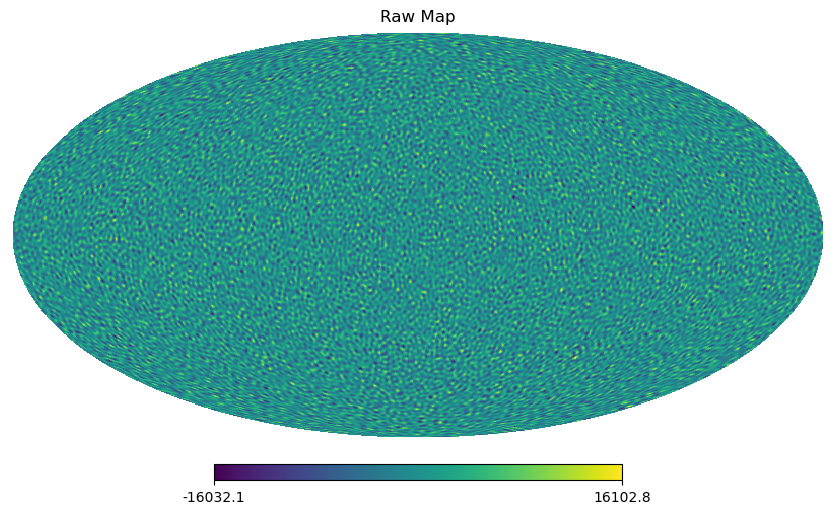

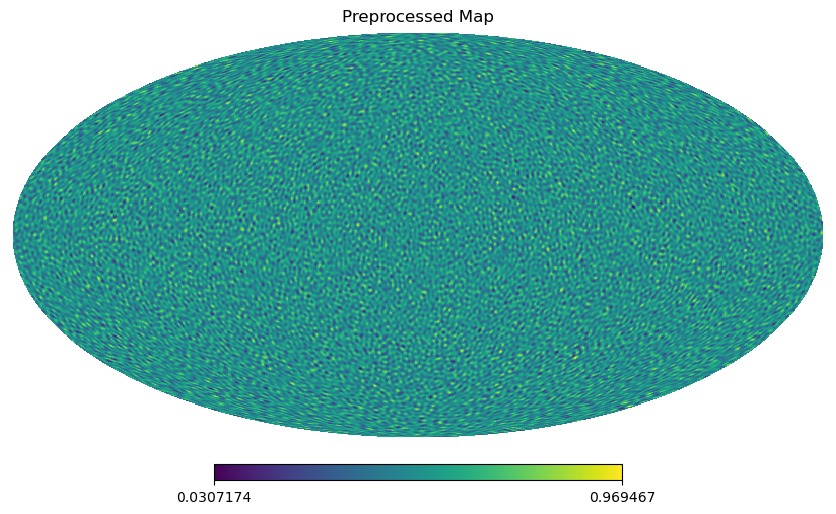

(1, 786432)

In [50]:
ex_ps2map = PS2MapExecutor(cfg)
ex_prep = DemoPrepExecutor(cfg)

with ex_ps2map.name_tracker.set_contexts({"split":"Valid", "sim_num":0}):
    raw_map_path = ex_ps2map.out_map_asset.path

out_raw_map = HealpyMap().read(raw_map_path)
hp.mollview(out_raw_map[0], title="Raw Map")
plt.show()

with ex_prep.name_tracker.set_contexts({"split":"Valid", "sim_num":0}):
    out_prep_path = ex_prep.out_map.path

out_prep_map = HealpyMap().read(out_prep_path)
hp.mollview(out_prep_map[0], title="Preprocessed Map")
plt.show()

out_raw_map.shape

In [51]:
(786432 / 12) ** 0.5

256.0

WHY ISN'T THIS NSIDE 32 ???

The difference can only be seen is in the scale bars.

# Full Pipeline

Now that each Executor has been built individually, the full pipeline can be run. Since I did all the development at a low $\textrm{N}_\textrm{side}=32$, I can override the Hydra config to run at a larger $\textrm{N}_\textrm{side}=256$ (feel free to use greater resolution, this is done so that the size on disk is minimized)

In [52]:
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", 
                  return_hydra_config=True,
                  overrides=["nside=256", "splits='3-140'"])
    HydraConfig.instance().set_config(cfg)

In [53]:
pipeline_context = PipelineContext(cfg)

pipeline_context.add_pipe(MakePSExecutor)
pipeline_context.add_pipe(PS2MapExecutor)
pipeline_context.add_pipe(ParallelFindStatsExecutor)
pipeline_context.add_pipe(DemoPrepExecutor)

pipeline_context.prerun_pipeline()

try:
    pipeline_context.run_pipeline()
except Exception as e:
    # I typically use the logging library for these messages
    logger.warning("An exception occured during the pipeline.", exc_info=e)
    raise e
finally:
    logger.info("Pipeline completed.")

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Skipping stage logs for stage MakePSExecutor.
Running PS2MapExecutor execute()
Power spectrum read from /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Working on split Train
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0002/cmb_map.fits
Working on sim 0003
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0003/cmb_map.fits
Working on sim 0004
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0004/cmb_map.fits
Working on sim 0005
Map written to /data/jim/CMB_Data/Datasets2/DemoNo

  0%|          | 0/120 [00:00<?, ?it/s]

Skipping stage logs for stage ParallelFindStatsExecutor.
Running DemoPrepExecutor execute()


Scaling:   0%|          | 0/100 [00:00<?, ?it/s, Loss=0]

Scaling:   0%|          | 0/20 [00:00<?, ?it/s, Loss=0]

Preprocessing complete.
Skipping stage logs for stage DemoPrepExecutor.
Pipeline completed.
